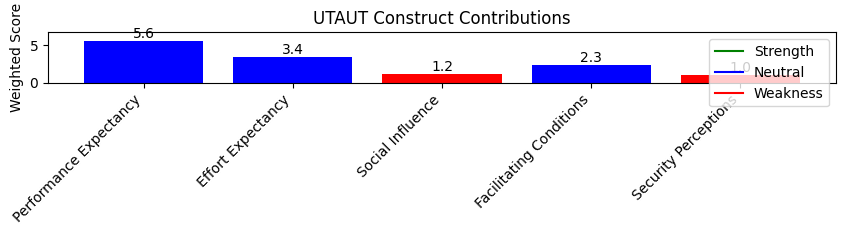

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

class UTAUTMFAPredictor:
    def __init__(self):
        # Initialize with the best model structure from your analysis
        self.model = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(
                class_weight='balanced_subsample',
                random_state=42,
                n_estimators=200))
        ])
        
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def calculate_utaut_score(self, X):
        """Calculate a composite UTAUT score (0-100 scale)"""
        # Normalize each construct score to 0-20 range (since we have 5 constructs)
        normalized_scores = X.values * 4  # Scale 1-5 to 4-20
        return normalized_scores.sum(axis=1)
    
    def explain_score(self, input_scores):
        """Explain the prediction based on input scores"""
        constructs = {
            'performance_expectancy': input_scores['Performance Expectancy'],
            'effort_expectancy': input_scores['Effort Expectancy'],
            'social_influence': input_scores['Social Influence'],
            'facilitating_conditions': input_scores['Facilitating Conditions'],
            'security_perceptions': input_scores['Security Perceptions']
        }
        
        # Calculate weighted scores (using typical UTAUT weights from literature)
        weights = {
            'performance_expectancy': 0.35,
            'effort_expectancy': 0.25,
            'social_influence': 0.15,
            'facilitating_conditions': 0.15,
            'security_perceptions': 0.10
        }
        
        weighted_scores = {
            construct: score * weight * 5  # Scale to 0-5 range for visualization
            for construct, score in constructs.items()
            for weight in [weights[construct]]
        }
        
        # Identify strengths and weaknesses
        strengths = []
        weaknesses = []
        
        for construct, score in constructs.items():
            if score >= 4.0:
                strengths.append(construct.replace('_', ' ').title())
            elif score <= 2.0:
                weaknesses.append(construct.replace('_', ' ').title())
        
        return {
            'construct_scores': {
                construct.replace('_', ' ').title(): {
                    'raw_score': score,
                    'weighted_score': weighted_scores[construct]
                }
                for construct, score in constructs.items()
            },
            'strengths': strengths,
            'weaknesses': weaknesses
        }

class MFAAdoptionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("UTAUT MFA Adoption Predictor")
        self.root.geometry("900x700")
        
        # Initialize the predictor (in a real app, you would load a trained model)
        try:
            self.scorer = UTAUTMFAPredictor()
            # For demo purposes, we'll "train" with dummy data matching your structure
            X_dummy = pd.DataFrame({
                'performance_expectancy_score': np.random.uniform(1, 5, 100),
                'effort_expectancy_score': np.random.uniform(1, 5, 100),
                'social_influence_score': np.random.uniform(1, 5, 100),
                'facilitating_conditions_score': np.random.uniform(1, 5, 100),
                'security_perceptions_score': np.random.uniform(1, 5, 100)
            })
            y_dummy = np.random.randint(0, 2, 100)
            self.scorer.model.fit(X_dummy, y_dummy)
        except Exception as e:
            messagebox.showerror("Error", f"Could not initialize the predictor: {str(e)}")
            self.root.destroy()
            return
        
        # Create main container
        self.main_frame = ttk.Frame(self.root, padding="10")
        self.main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Input Section
        self.create_input_section()
        
        # Results Section
        self.create_results_section()
        
        # Visualization Section
        self.create_visualization_section()
        
        # Add some styling
        self.style = ttk.Style()
        self.style.configure('TFrame', background='#f0f0f0')
        self.style.configure('TLabel', background='#f0f0f0', font=('Arial', 10))
        self.style.configure('TButton', font=('Arial', 10))
        self.style.configure('Header.TLabel', font=('Arial', 12, 'bold'))
        
    def create_input_section(self):
        """Create the input form for UTAUT construct scores"""
        input_frame = ttk.LabelFrame(self.main_frame, text="Input UTAUT Construct Scores (1-5 scale)", padding="10")
        input_frame.pack(fill=tk.X, pady=5)
        
        # Dictionary to store input variables
        self.input_vars = {}
        
        constructs = [
            "Performance Expectancy",
            "Effort Expectancy", 
            "Social Influence",
            "Facilitating Conditions",
            "Security Perceptions"
        ]
        
        for i, construct in enumerate(constructs):
            # Create label
            label = ttk.Label(input_frame, text=f"{construct}:")
            label.grid(row=i, column=0, sticky=tk.W, padx=5, pady=2)
            
            # Create scale widget (1-5)
            var = tk.DoubleVar(value=3.0)
            scale = ttk.Scale(input_frame, from_=1, to=5, variable=var, 
                             orient=tk.HORIZONTAL, length=200,
                             command=lambda v, c=construct: self.update_entry(v, c))
            scale.grid(row=i, column=1, padx=5, pady=2)
            
            # Create entry box to show exact value
            entry = ttk.Entry(input_frame, width=5, 
                             textvariable=var)
            entry.grid(row=i, column=2, padx=5, pady=2)
            
            self.input_vars[construct] = var
        
        # Add predict button
        predict_btn = ttk.Button(input_frame, text="Predict MFA Adoption", 
                               command=self.predict_adoption)
        predict_btn.grid(row=len(constructs), column=1, pady=10)
    
    def update_entry(self, value, construct):
        """Update the entry box when scale is moved"""
        self.input_vars[construct].set(round(float(value), 1))
    
    def create_results_section(self):
        """Create the section to display prediction results"""
        results_frame = ttk.LabelFrame(self.main_frame, text="Prediction Results", padding="10")
        results_frame.pack(fill=tk.X, pady=5)
        
        # Probability of adoption
        ttk.Label(results_frame, text="Probability of MFA Adoption:").grid(row=0, column=0, sticky=tk.W)
        self.probability_label = ttk.Label(results_frame, text="", font=('Arial', 10, 'bold'))
        self.probability_label.grid(row=0, column=1, sticky=tk.W)
        
        # Prediction
        ttk.Label(results_frame, text="Prediction (threshold=0.5):").grid(row=1, column=0, sticky=tk.W)
        self.prediction_label = ttk.Label(results_frame, text="", font=('Arial', 10, 'bold'))
        self.prediction_label.grid(row=1, column=1, sticky=tk.W)
        
        # Composite score
        ttk.Label(results_frame, text="Composite UTAUT Score:").grid(row=2, column=0, sticky=tk.W)
        self.score_label = ttk.Label(results_frame, text="", font=('Arial', 10, 'bold'))
        self.score_label.grid(row=2, column=1, sticky=tk.W)
        
        # Strengths
        ttk.Label(results_frame, text="Strengths:").grid(row=3, column=0, sticky=tk.W)
        self.strengths_label = ttk.Label(results_frame, text="", wraplength=400)
        self.strengths_label.grid(row=3, column=1, sticky=tk.W)
        
        # Weaknesses
        ttk.Label(results_frame, text="Areas for Improvement:").grid(row=4, column=0, sticky=tk.W)
        self.weaknesses_label = ttk.Label(results_frame, text="", wraplength=400)
        self.weaknesses_label.grid(row=4, column=1, sticky=tk.W)
    
    def create_visualization_section(self):
        """Create the section for visualizations"""
        vis_frame = ttk.LabelFrame(self.main_frame, text="Visualization", padding="10")
        vis_frame.pack(fill=tk.BOTH, expand=True, pady=5)
        
        # Create matplotlib figure
        self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=100)
        self.canvas = FigureCanvasTkAgg(self.fig, master=vis_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Initial empty plot
        self.ax.set_title("UTAUT Construct Contributions")
        self.ax.set_ylabel("Score")
        self.canvas.draw()
    
    def predict_adoption(self):
        """Make prediction based on input values"""
        try:
            # Get input values
            input_data = {
                f"{construct.lower().replace(' ', '_')}_score": var.get()
                for construct, var in self.input_vars.items()
            }
            
            # Create DataFrame for prediction
            input_df = pd.DataFrame([input_data])
            
            # Get predictions
            probability = self.scorer.predict_proba(input_df)[0][1]  # Probability of class 1 (adoption)
            prediction = self.scorer.predict(input_df)[0]
            composite_score = self.scorer.calculate_utaut_score(input_df)[0]
            
            # Get explanation
            explanation = self.scorer.explain_score({
                construct: var.get()
                for construct, var in self.input_vars.items()
            })
            
            # Update results display
            self.probability_label.config(text=f"{probability:.1%}")
            self.prediction_label.config(
                text="Likely to Adopt" if prediction else "Unlikely to Adopt",
                foreground="green" if prediction else "red"
            )
            self.score_label.config(text=f"{composite_score:.0f}/100")
            self.strengths_label.config(text=", ".join(explanation['strengths']) or "None")
            self.weaknesses_label.config(text=", ".join(explanation['weaknesses']) or "None")
            
            # Update visualization
            self.update_visualization(explanation)
            
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred during prediction:\n{str(e)}")
    
    def update_visualization(self, explanation):
        """Update the visualization with current results"""
        self.ax.clear()
        
        # Prepare data for plotting
        constructs = []
        scores = []
        colors = []
        
        for construct, data in explanation['construct_scores'].items():
            constructs.append(construct)
            scores.append(data['weighted_score'])
            
            # Color based on whether it's a strength or weakness
            if construct in explanation['strengths']:
                colors.append('green')
            elif construct in explanation['weaknesses']:
                colors.append('red')
            else:
                colors.append('blue')
        
        # Create bar plot
        bars = self.ax.bar(constructs, scores, color=colors)
        
        # Add labels and title
        self.ax.set_title("UTAUT Construct Contributions")
        self.ax.set_ylabel("Weighted Score")
        self.ax.set_ylim(0, max(scores) * 1.2)
        
        # Rotate x-axis labels
        plt.setp(self.ax.get_xticklabels(), rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            self.ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}',
                        ha='center', va='bottom')
        
        # Add legend
        self.ax.plot([], [], color='green', label='Strength')
        self.ax.plot([], [], color='blue', label='Neutral')
        self.ax.plot([], [], color='red', label='Weakness')
        self.ax.legend()
        
        # Tight layout and redraw
        self.fig.tight_layout()
        self.canvas.draw()

def main():
    root = tk.Tk()
    app = MFAAdoptionApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()